In [568]:
import numpy as np

import torch
from torch import nn

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [569]:
#data set generation where the input is taken from the user
def generate(data_size):
    X = []
    y = []

    for i in range(data_size):
        seq_len = np.random.randint(2,20)
        x_sample = torch.zeros((2,seq_len),dtype = torch.float)
        indices = np.random.choice(seq_len,2,replace = False)
        x_sample[1,indices] = 1
        x_sample[0,:] = torch.rand(seq_len,dtype = torch.float)
        y_sample = torch.sum(x_sample[0,indices])
        X.append(x_sample)
        y.append(y_sample)
    
    #Splitting the data into training and testing data sets
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.01,random_state=42)
    y_test = torch.tensor(y_test)
    y_train = torch.tensor(y_train)
    return X_train,y_train,X_test,y_test

In [570]:
#defining our loss function which we are going to use our model
def square_loss(y,y_pred):
    len = y_pred.shape[0]
    y_pred.reshape(len,1)
    y.reshape(len,1)

    loss = torch.mean((y - y_pred)**2)
    return loss


#Defining our activation functions of tanh and sigmoid
def tanh(x):
    return (torch.exp(x) - torch.exp(-x))/(torch.exp(x) + torch.exp(-x))

def sigmoid(x):
    return 1/(1 + torch.exp(-x))

In [571]:
#Now we define our class for elmon RNN
class ElmonRNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(ElmonRNN,self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        #Now we define our parameters
        self.W_xh = nn.parameter.Parameter(torch.randn(hidden_size,input_size),requires_grad= True)
        self.b_h = nn.parameter.Parameter(torch.randn(hidden_size,1),requires_grad= True)
        self.W_hh = nn.parameter.Parameter(torch.randn(hidden_size,hidden_size,requires_grad = True))

        self.W_hy = nn.parameter.Parameter(torch.randn(output_size,hidden_size),requires_grad= True)
        self.b_y = nn.parameter.Parameter(torch.randn(output_size,1),requires_grad= True)
    
    #Defining our forward function
    def forward(self,X):
        seq_len  = len(X)
        # seq_len = 2
        h = torch.zeros((self.hidden_size,1),requires_grad= True)
        
        for i in range(seq_len):
            x = X[:,i].reshape(2,1)
            # x = X.reshape(2,1)
            h_xh  = (self.W_xh @ x).reshape(self.hidden_size,1) 
            h_hh = self.W_hh @ h.reshape(self.hidden_size,1)
            b_h = self.b_h.reshape(self.hidden_size,1)
            h = tanh(h_xh + h_hh + b_h)
            
        y_pred = self.W_hy @ h + self.b_y.reshape(1,1)

        return y_pred



In [572]:
#defining our class for LSTM RNN
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(LSTM,self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.h = None
        self.c = None


        #defining our parameters
        #parameters for forward gate
        self.wf = nn.parameter.Parameter(torch.randn(hidden_size,hidden_size + input_size),requires_grad = True)
        self.bf = nn.parameter.Parameter(torch.randn(hidden_size,1),requires_grad = True)

        #Parameters for input gate
        self.wi = nn.parameter.Parameter(torch.randn(hidden_size,hidden_size + input_size),requires_grad = True)
        self.bi = nn.parameter.Parameter(torch.randn(hidden_size,1),requires_grad = True)

        #Parameters for cell
        self.wc = nn.parameter.Parameter(torch.randn(hidden_size,hidden_size + input_size),requires_grad = True)
        self.bc = nn.parameter.Parameter(torch.randn(hidden_size,1),requires_grad = True)

        #Paramters for output gate
        self.wo = nn.parameter.Parameter(torch.randn(hidden_size,hidden_size + input_size),requires_grad = True)
        self.bo = nn.parameter.Parameter(torch.randn(hidden_size,1),requires_grad = True)

        #Weights and biases which help us get y pred
        self.wy = nn.parameter.Parameter(torch.randn(output_size,hidden_size),requires_grad = True)
        self.by = nn.parameter.Parameter(torch.randn(output_size,1),requires_grad = True)

    #defining our forward function
    def forward(self,X):
        seq_len = len(X)
        # seq_len = 2
        h = torch.zeros((self.hidden_size,1),requires_grad=True)
        c = torch.zeros((self.hidden_size,1),requires_grad=True)

        for i in range(seq_len):
            x = X[:,i].reshape(2,1)
            # x = X.reshape(2,1)
            concat = torch.cat((h,x))
            
            f = sigmoid(self.wf @ concat + self.bf)
            i = sigmoid(self.wi @ concat + self.bi)
            c_tilda = tanh(self.wc @ concat + self.bc)

            c = torch.mul(f,c) + torch.mul(i,c_tilda)
            
            o = sigmoid(self.wo @ concat + self.bo)
            h = torch.mul(o,tanh(c))
        
        y_pred = self.wy @ h + self.by
        # print(y_pred.shape)
        return y_pred
            
        

In [573]:
#defining our GRU RNN class
class GRU(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(GRU,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        #defining our parameters
        self.wr = nn.parameter.Parameter(torch.randn(hidden_size,hidden_size + input_size),requires_grad=True)
        self.wz = nn.parameter.Parameter(torch.randn(hidden_size,hidden_size + input_size),requires_grad=True)

        self.w = nn.parameter.Parameter(torch.randn(hidden_size,hidden_size + input_size),requires_grad=True)

        self.wy = nn.parameter.Parameter(torch.randn(output_size,hidden_size),requires_grad=True)
        self.by = nn.parameter.Parameter(torch.randn(output_size,1),requires_grad=True)


    #defining our forward function
    def forward(self,X):
        h = torch.zeros((self.hidden_size,1),requires_grad=True)
        seq_len = len(X)
        # seq_len = 2

        for i in range(seq_len):
            x = X[:,i].reshape(2,1)
            # x = X.reshape(2,1)

            concat1 = torch.cat((h,x))
            z = sigmoid(self.wz @ concat1)
            r = sigmoid(self.wr @ concat1)

            h_temp = r*h
            # print(h_temp.shape)
            concat2 = torch.cat((h_temp,x))
            # print(concat2.shape)

            h_tilda = tanh(self.w @ concat2)
            h = (1-z)*h+ z*h_tilda
        
        y_pred = self.wy @ h + self.by
        return y_pred


In [574]:
#defining our train function which trains the model for a single epoch
#the function also returns loss which helps us plot learning curves
def train_single(model,X,y,learning_rate):
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
    y_pred = torch.zeros((len(X),1))
    for i in range(len(X)):
        y_pred[i] = model(X[i])
    loss = square_loss(y,y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return model,loss.item()

#defining our test function which helps in building our perfomance curves
def test(model,X,y):
    y_pred = torch.zeros((len(X),1))
    for i in range(len(X)):
        y_pred[i] = model(X[i])
    loss = square_loss(y,y_pred)

    return loss.item()
        

In [575]:
#defining new loss function
def new_loss(y,y_pred):
    return ((y-y_pred)**2)

In [576]:
def train_sample(model, x, y,learning_rate):
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
    y_pred = model(x)
    loss = new_loss(y,y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return model, loss.item()

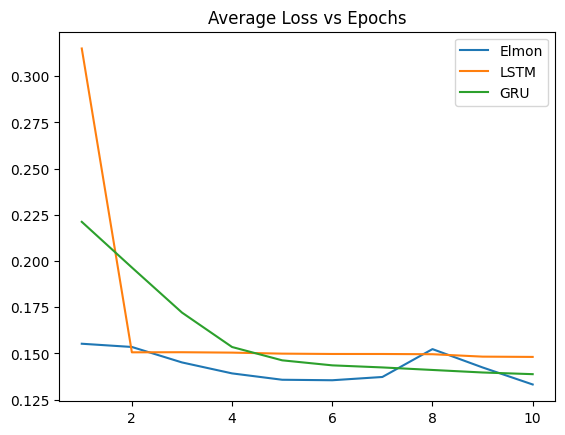

In [583]:
#Defining our models
hidden_size = 3
model_elmon = ElmonRNN(2,6,1)
model_gru = GRU(2,6,1)
model_lstm = LSTM(2,6,1)
epochs = 10
data_size = 5000
#generating dataset
X_train,y_train,X_test,y_test = generate(data_size)

#Empty lists which hold loss corresponding to each model
loss_elmon_train = []
loss_lstm_train = []
loss_gru_train = []

loss_elmon_test = []
loss_lstm_test = []
loss_gru_test  = []

#Training the models for n epochs
for _ in range(epochs):
    loss_elmon_epoch = []
    loss_lstm_epoch = []
    loss_gru_epoch = []
    for i in range(len(X_train)):
        model_elmon,loss_elmon = train_sample(model_elmon,X_train[i],y_train[i],0.003)
        model_lstm,loss_lstm = train_sample(model_lstm,X_train[i],y_train[i],0.001)
        model_gru,loss_gru = train_sample(model_gru,X_train[i],y_train[i],0.001)
        loss_elmon_epoch.append(loss_elmon)
        loss_lstm_epoch.append(loss_lstm)
        loss_gru_epoch.append(loss_gru)

    loss_elmon_train.append(np.mean(np.array(loss_elmon_epoch)))
    loss_lstm_train.append(np.mean(np.array(loss_lstm_epoch)))
    loss_gru_train.append(np.mean(np.array(loss_gru_epoch)))

    loss_elmon_test_val = test(model_elmon,X_test,y_test)
    loss_lstm_test_val = test(model_lstm,X_test,y_test)
    loss_gru_test_val = test(model_gru,X_test,y_test)

    loss_elmon_test.append(loss_elmon_test_val)
    loss_lstm_test.append(loss_lstm_test_val)
    loss_gru_test.append(loss_gru_test_val)


x_axis = [i for i in range(1,epochs+1)]
plt.plot(x_axis,loss_elmon_train)
plt.plot(x_axis,loss_lstm_train)
plt.plot(x_axis,loss_gru_train)
plt.legend(["Elmon","LSTM","GRU"])
plt.title("Average Loss vs Epochs")
plt.show()

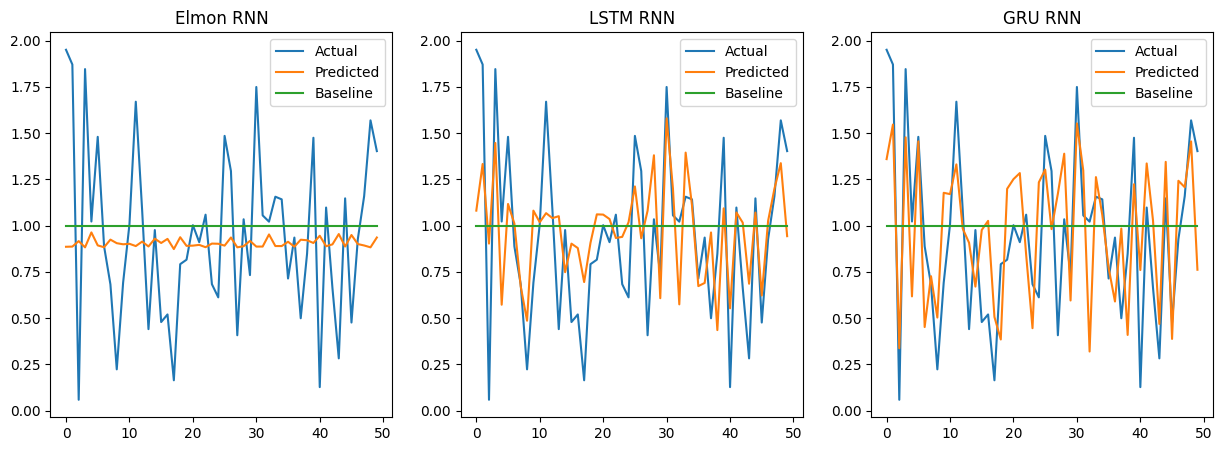

In [578]:
x_axis2 = [i for i in range(len(X_test))]
y = [1 for i in range(len(X_test))]
y_elmon = [model_elmon(x).item() for x in X_test]
y_lstm = [model_lstm(x).item() for x in X_test]
y_gru = [model_gru(x).item() for x in X_test]


fig,axs = plt.subplots(1,3,figsize =(15,5))
axs[0].plot(x_axis2, y_test)
axs[0].plot(x_axis2,y_elmon)
axs[0].plot(x_axis2,y)
axs[0].set_title('Elmon RNN')
axs[0].legend(["Actual","Predicted","Baseline"])
axs[1].plot(x_axis2, y_test)
axs[1].plot(x_axis2,y_lstm)
axs[1].plot(x_axis2,y)
axs[1].set_title('LSTM RNN')
axs[1].legend(["Actual","Predicted","Baseline"])
axs[2].plot(x_axis2, y_test)
axs[2].plot(x_axis2,y_gru)
axs[2].plot(x_axis2,y)
axs[2].set_title('GRU RNN')
axs[2].legend(["Actual","Predicted","Baseline"])

Observartions\
We can observe that even after training elmon it gives a prediction close to baseline with testing data but with trainig data it has the least loss so overfitting has taken place but lstm and gru rnn models no overfitting has taken place

The gradient descent we have performed is stochastic gradient descent and hence our weight parameter gets updated a huge number of times reducing the loss to 0.1sh for the 3 cases.

where as if we peroform batch gradient descent the loss is hovering near 0.2 for all the 3 cases.